In [211]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import random
import time
import vk
import json
import traceback
import json
import snap
from networkx.algorithms import community
from matplotlib.pyplot import figure
session = vk.Session(access_token='4c7c952b4c7c952b4c7c952bf14c1a736544c7c4c7c952b179d212fd48229afe166e816')
vk_api = vk.API(session)
options = {   # опции для отрисовки графа
  #  'node_color': 'black',
    'node_size': 200,
    'width': 1,
   # 'font_weight': 'bold',
    'with_labels':True
}


In [212]:
# маленький бот, который умеет печатать в личку отчёт из print
python_bot_session = vk.Session(access_token='a8dede3a2d1a42fa9bc495db9b437ca55671824c985d1faa77371943a6d36b5508021a74cadc36b645cae')
python_bot = vk.API(python_bot_session)
# функция, которая печатает и на экран и в указанную

attachments = []
# по умолчанию мой idшник вк(Денис)
def myprint(*message_array):
    #message = [i for i in message.replace(',', ' ').split()]
    message_list =[i for i in message_array]
    message = ''
    for i in message_list:
        message+=' '+ str(i)
    peer_id = '110014788'
    
    attachment = ''
    # TBD: разобраться с Attachments
    print(message)
    
    return python_bot.messages.send(v = '5.89',user_id = peer_id, message = message, attachment = ','.join(attachments))
    #return 0

#myprint('Hi', 'Hello', options)


In [214]:
# Работа с графами. Выбирается один из списка (всё определяет graph_name и *_graph) 
graph_name = 'wikivote'  
myprint("---------------------------------------------------\n Running graph"+graph_name+" \n----------------")

#fh=open("importing.txt", 'rb')
t0 = time.time() 
#первое слово выбрать из списка: importing   dblp2010   github   wikivote   slashdot
graph_name_list = ['importing',  'dblp2010',  'github','wikivote','DCAM','hamsterster','gnutella']  #'slashdot',
graph_list = []
fh=open('./Graphs/'+graph_name+ ".edges", 'rb')
Graph=nx.read_edgelist(fh, delimiter = ' ')#,create_using=nx.Graph())
fh.close()
#print(Graph.nodes())
graph_components = [Graph.subgraph(c) for c in nx.connected_components(Graph)] # выводим длины компонент
print('components lenght', [len(i) for i in graph_components]) 
Graph = max(nx.connected_component_subgraphs(Graph), key=len) # берём за граф только самую большую его компоненту 

Graph.remove_edges_from(Graph.selfloop_edges())  # удаляем петли
print('Nodes: ',Graph.number_of_nodes(),' edges',Graph.number_of_edges())
#dblp201_graph = Graph
#wikivote_graph = Graph
#slashdot_graph = Graph
#github_graph = Graph
#nx.draw(Graph, with_labels=False ,node_size = 30)
myprint(int(time.time() -t0) , 'sec')




 ---------------------------------------------------
 Running graphwikivote 
----------------
components lenght [889]
Nodes:  889  edges 2914
 0 sec


1359

889
is connected True
component count 1
None
almost empty 0
889
889 total
exported in./Sampling/wikivote_BIG.graph


/home/denisaivazov/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


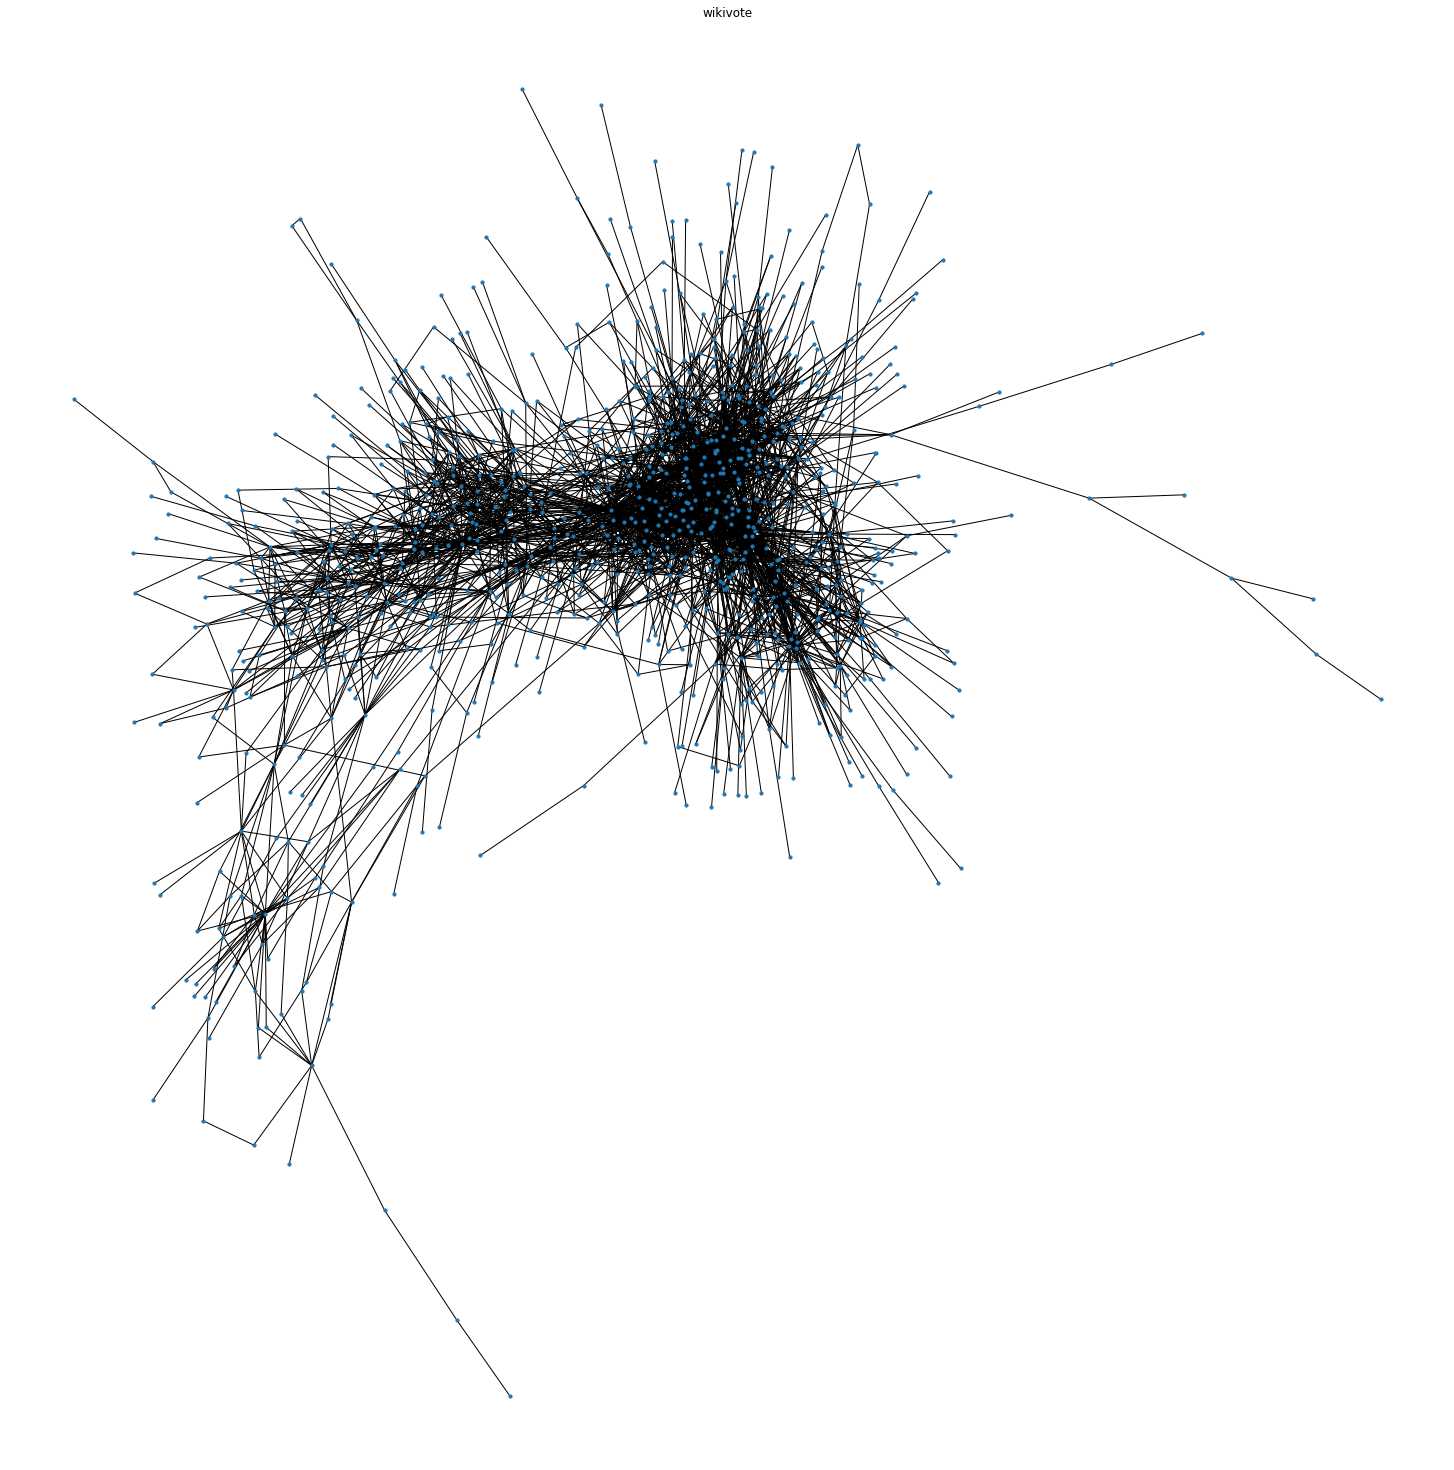

4 sec


In [215]:
# Определение числа компонент связности, берём самую большую. И ещё сохраняем граф

t0 = time.time() 
print(Graph.number_of_nodes())
print('is connected',nx.is_connected(Graph))

print('component count', nx.number_connected_components(Graph))
components = [Graph.subgraph(c) for c in nx.connected_components(Graph)]
almost_empty_count = 0
budget_graph = components[0]
subgraph_nodes = []
for subgraph in components:
    subgraph_nodes.append(subgraph.number_of_nodes())
    if subgraph.number_of_nodes() == 1:
        almost_empty_count +=1
print(subgraph_nodes.sort())
print('almost empty',almost_empty_count)
print( len(Graph.nodes))

#budget_set = set()
#for i in budget_graph.nodes():
#    budget_set.add(i)
total = max([Graph.subgraph(c).number_of_nodes() for c in nx.connected_components(Graph)])
print(total, 'total')


# сразу экспортируем граф
nx.write_gml(Graph, "./Graphs/"+ graph_name +'_BIG.graph')
print('exported in'+"./Sampling/"+ graph_name +'_BIG.graph')

plt.figure(figsize=(20,20))
if Graph.number_of_nodes()<3000:
    nx.draw(Graph, with_labels=False ,edge_cmap=plt.cm.Blues , node_size = 10)
    plt.title(graph_name)
    plt.savefig('./Sampling/'+graph_name+'/Graph.png')
    plt.show()
print(int(time.time() -t0) , 'sec')

In [218]:
# берём квантиль примерно на top_percent лучших вершин. 
# Квантиль это словарь quantile['degrees']=24 значит что топ вершин с макс степенью имеют степени 24 и больше
json_file = open('./Graphs/'+graph_name+'_properties.txt','r')
properties = json.load(json_file)
print([i for i in properties])
method_history_fields = ['degrees', 'k_cores','eccentricity','betweenness_centrality']



plt.figure(figsize=(13,13))
#print(properties)
total = Graph.number_of_nodes()
top_percent = 10
quantile = {'degrees':[],'k_cores':[],'eccentricity':[],'betweenness_centrality':[]}
quantile_history = {'degrees':[],'k_cores':[],'eccentricity':[],'betweenness_centrality':[]}



quantile_numpy = {}
quantile_set = {}
prop_color = {'degrees':'green','k_cores':'black','eccentricity':'red','betweenness_centrality':'blue'}
for prop in method_history_fields:
    #print(prop,properties[prop])
    quantile[prop] = properties[prop][min(int(total*top_percent//100),len(properties[prop]))-1]

    quantile_set[prop] = set([node for node in properties[prop+'_dict'] if properties[prop+'_dict'][node]>=quantile[prop]])

    #quantile_numpy[prop] = np.array(properties[prop+'_dict'])
    #quantile[prop] = np.percentile(properties[prop],top_percent)

    #print(quantile)
    #quantile_set[prop] = set(i for i in quantile_numpy[prop] if i>=quantile[prop])
    #print('quantile_set',quantile_set)
    #quantile[prop] = properties[prop][int((total*top_percent))]

    quantile_history[prop].append(len(quantile_set[prop]))
    #quantile_set['eccentricity']   =  set([node for node in properties['eccentricity'+'_dict'] if properties['eccentricity'+'_dict'][node]<=quantile['eccentricity']])
    #save_quantile = dict((prop,quantile[prop]) for prop in method_history_fields)
    #save_quantile_set =  dict((prop,quantile_set[prop]) for prop in method_history_fields)
        
print('percent:',top_percent,' quantile',quantile)
    

['number_of_nodes', 'number_of_edges', 'degrees', 'degrees_dict', 'd_avg', 'k_cores', 'k_cores_dict', 'community_counter', 'community_coverage', 'community_performance', 'eccentricity', 'eccentricity_dict', 'betweenness_centrality', 'betweenness_centrality_dict']
percent: 10  quantile {'degrees': 15, 'k_cores': 7, 'eccentricity': -8, 'betweenness_centrality': 0.008199457386916775}


<Figure size 936x936 with 0 Axes>

In [221]:
b = min(1000000,int(total*0.90))
seed_count = 5




t00 = time.time()
all_history = []
#plt.plot([total]*b) # верхняя линия  # TBD: верхняя линия размером с самую большую компоненту


linestiles = [':', '--', '-.','--']*seed_count
seeds = random.sample(set(Graph.nodes),seed_count) # список начальных вершин, по которым мы будем проходиться
methods = ['RW','RC','DFS', 'BFS', 'MED','MOD'] #'AFD',

myprint("b=",b,"seed count=",seed_count, "methods:",methods)
method_color = {'AFD':'pink','RC':'grey','RW':'green','DFS':'black', 'BFS':'blue', 'MED':'cyan','MOD':'red'}
#method_history_one = 
method_history = dict((method, {'nodes':np.zeros([len(methods)*seed_count,total+1]),
                                  'degrees':[],
                                  'k_cores':[],
                                  'eccentricity':[],
                                  'betweenness_centrality':[]}) for method in methods)




 b= 800 seed count= 5 methods: ['RW', 'RC', 'DFS', 'BFS', 'MED', 'MOD']


In [225]:
class Crawler:
    def __init__(self,Graph,node_seed,budget,quantile_set,method_history_fields):
        self.big_graph = Graph # сам конечный граф
        self.b = budget # бюджет запросов, которые можно сделать
        self.node_seed = node_seed # начальная сида, с которой начинаем
        self.quantile_set = quantile_set # множество вершин графа, удовлетворяющих квантилю
        self.method = 'RC'
        
        self.total = self.big_graph.number_of_nodes() # total это общее число вершин
        self.current = node_seed  # в начале текущая вершина это стартовая нода
        self.v_observed = set()   # множество увиденных вершин
        self.v_observed.add(node_seed)  
        self.v_closed = set()  # множество уже обработанных вершин
        self.node_degree = [] # общее число друзей вершины. А не в бюджетном
        self.node_array = []  # последовательность вершин, которые мы обходим
        self.G = nx.Graph()         # наш насемплированный граф
        self.G.add_node(node_seed)  # добавляем начальную вершину
        
        self.property_fields = method_history_fields # список названий полей из properties графа, которые исследуем
        self.counter = 0            # счётчик итераций
        self.observed_history = [0] # история изменения количества видимых вершин
## вот тут мб надо немного переделать
        self.property_history = dict((i,[]*self.total) for i in method_history_fields) # история изменения параметров с итерациями
        for prop in method_history_fields:
            self.property_history[prop].append(len(self.v_closed.intersection(self.quantile_set[prop])))
            
        self.node_degree = [] # общее число друзей вершины. А не в бюджетном
        self.node_array = []  # список вершин в порядке обработки
        
        #self.plot, _ = plt.subplots()
        #print(type())
    
    

    def observing(self):
        """
        пробегаемся по всем друзьям и добавляем их в наш граф и в v_observed
        """
        for friend_id in list(self.big_graph.adj[self.current]):
            if friend_id not in self.v_closed:
                self.v_observed.add(friend_id)
                self.G.add_node(friend_id)
                self.G.add_edge(friend_id,self.current)
            
        
    def change_current(self): # выбор новой вершины. по умолчанию считаем random crawling
        raise NotImplementedError()
    
    def draw(self):
        #print(self.observed_history)
        pass
        return plt.plot(self.observed_history)
        
    def sampling_process(self): # сам  процесс сэмплирования
        while(self.counter<self.total)and(len(self.v_observed)>0)and(self.counter<self.b):
            #print(self.current, self.v_observed, self.v_closed)
            self.change_current()
            self.observing()
            if self.current in self.v_observed: # условие для пустых итераций рандом волка tbd - надо исправить
                self.v_observed.remove(self.current) # теперь она обработанная, а не просто видимая
            self.v_closed.add(self.current)
            self.node_array.append(self.current) # отметили, что обработали эту вершину
            self.observed_history.append(len(self.v_observed)+len(self.v_closed))
            
        # отдельно пробегаемся по всем     
            
            
            for prop in method_history_fields:
                self.property_history[prop].append(len(self.v_closed.intersection(self.quantile_set[prop])))
                #print(self.property_history,prop,self.counter)
                #self.property_history[prop][self.counter]+=len(self.v_closed.intersection(self.quantile_set[prop]))
            self.counter+=1
            
        #self.draw()
        return self.observed_history#,self.property_history)
    
    # раскомментить если захочется экспортировать граф
    #nx.write_gml(G, "./Sampling/"+ graph_name +"/"+method+'_b='+str(b)+'_seed='+str(n_seed)+'.graph')

class Crawler_RW(Crawler):
    def __init__(self,Graph,node_seed,budget,quantile_set,method_history_fields):
        Crawler.__init__(self,Graph,node_seed,budget,quantile_set,method_history_fields)
        self.method = 'RW'
        self.previous = self.current
        
    def sampling_process(self):
        self.previous = self.node_seed
        super().sampling_process()
        self.previous = self.current
    
    def change_current(self):
        #print(self.previous)
        new_node = random.sample(set(self.big_graph.adj[self.previous]),1)[0]
        while new_node in self.v_closed:
            self.previous = new_node
            new_node = random.sample(set(self.big_graph.adj[self.previous]),1)[0]
            #print('whiling in ',new_node,'and his friends',big_graph.adj[previous])
        self.current = new_node
            
    


In [226]:
class Crawler_RC(Crawler):
    def change_current(self):
        self.current = random.sample(self.v_observed,1)[0]

class Crawler_DFS(Crawler):
    def __init__(self,Graph,node_seed,budget,quantile_set,method_history_fields):
        Crawler.__init__(self,Graph,node_seed,budget,quantile_set,method_history_fields)
        self.method = 'DFS'
        self.dfs_counter = 0
        self.dfs_queue = [self.node_seed]
    
    def change_current(self): # полностью переопределяем метод
        while (self.dfs_queue[0] not in self.v_observed):
            self.dfs_queue.pop(0)
        self.current = self.dfs_queue[0] 
    
    def friends_adding(self):
        super().friends_adding()
        
        
    def observing(self):
        self.dfs_counter = 0
        for friend_id in list(self.big_graph.adj[self.current]):
            if friend_id not in self.v_closed:
                self.v_observed.add(friend_id)
                self.G.add_node(friend_id)
                self.G.add_edge(friend_id,self.current)
                self.dfs_counter +=1
                self.dfs_queue.insert(self.dfs_counter,friend_id)
        if self.current in self.v_observed:
            self.dfs_queue.remove(self.current)
        
            
class Crawler_MOD(Crawler):
    def __init__(self,Graph,node_seed,budget,quantile_set,method_history_fields):
        Crawler.__init__(self,Graph,node_seed,budget,quantile_set,method_history_fields)
        self.method = 'MOD'
        self.graph_for_max_deg = self.G
        
    def change_current(self):
        maximal,max_id = 0, random.sample(self.v_observed,1)[0] # берём случайную вершину за основу
        for i in self.v_observed:
            if maximal<self.graph_for_max_deg.degree(i):
                maximal,max_id = self.graph_for_max_deg.degree(i),i
        self.current = max_id


class Crawler_MED(Crawler_MOD): # унаследовали от MOD только степени берём из большого графа
    def __init__(self,Graph,node_seed,budget,quantile_set,method_history_fields):
        Crawler.__init__(self,Graph,node_seed,budget,quantile_set,method_history_fields)
        self.method = 'MED'
        self.graph_for_max_deg = self.big_graph



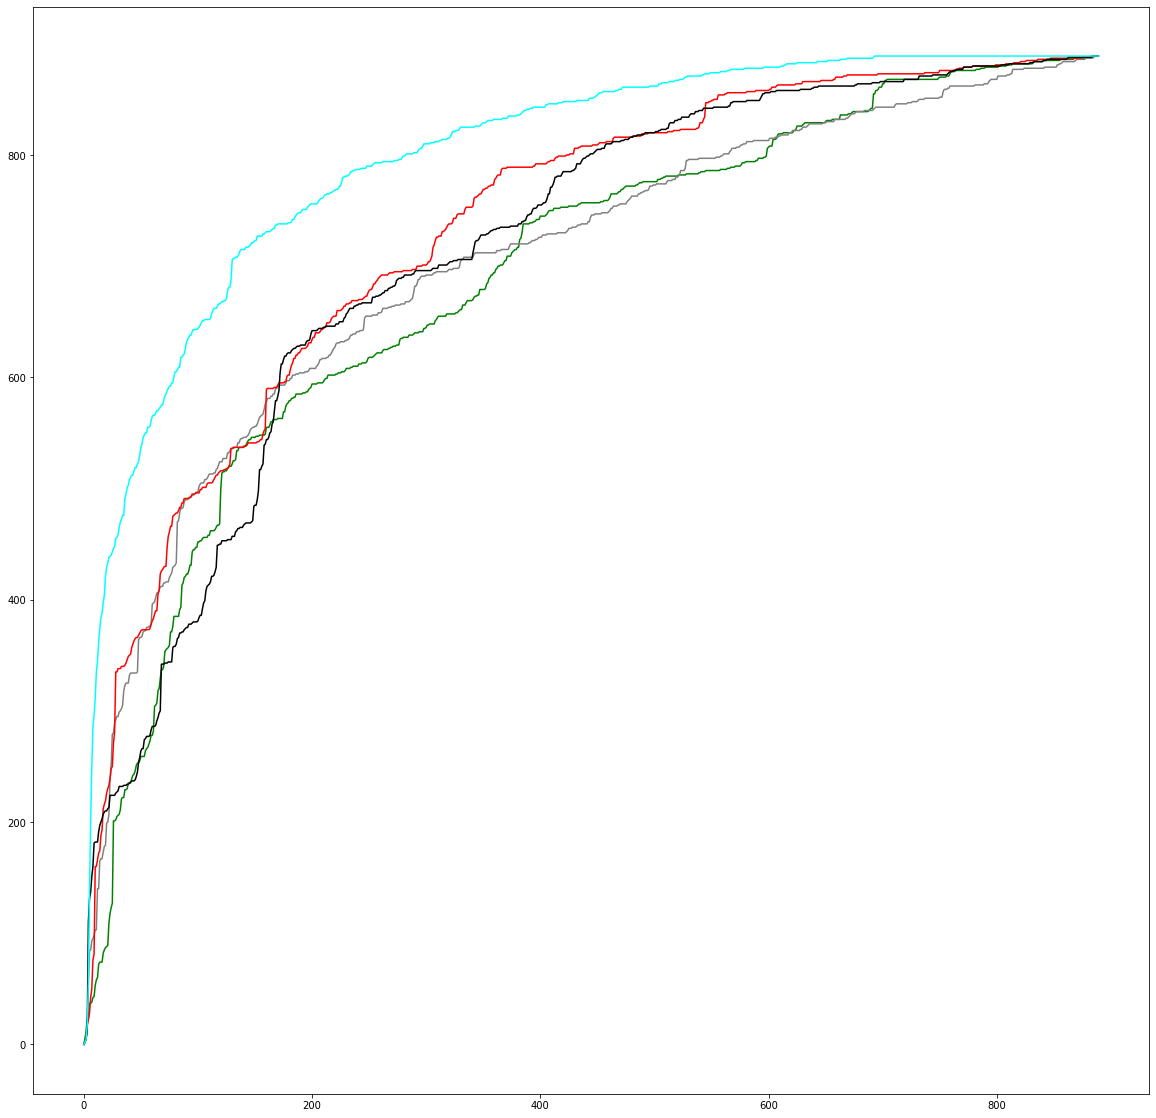

set()


In [228]:

        
crawler = []    
plt.figure(figsize=(20,20))
choose_crawler = [Crawler_RW,Crawler_RC,Crawler_MOD,Crawler_DFS, Crawler_MED]
        
seeds = random.sample(set(Graph.nodes),1)[0]
for i in range(1):
    for cr in choose_crawler: 
        crawler.append(cr(Graph,seeds,1000,quantile_set, method_history_fields))
        crawler[-1].sampling_process()
        #plt.plot(method_history[method ]['nodes'][method_counter][:b]/seed_counter, linewidth = 5, color = method_color[method], label = method)
        plt.plot(crawler[-1].observed_history, color = method_color[crawler[-1].method])
    
        #crawler.append(Crawler_DFS(Graph,random.sample(set(Graph.nodes),1)[0],1000,quantile_set, method_history_fields))
       # crawler[i].sampling_process()
       # plt.plot(crawler[i].observed_history, color = method_color[crawler[i].method])
plt.show()
print(crawler[-1].v_observed)   


In [ ]:
## дописать всё связанное с параметрами